---
title: "Exemplo de classificação - Aula 04"
format:
  html:
    toc: true
    toc-title: Sumário
    toc-location: left
    toc-depth: 4
    html-math-method: katex
    code-line-numbers: true
    css: aulas.css
---

* Notebook complementar para a [Aula 04](./aula-04.html)
* Responsável: Prof. Dr. Hugo Cristo Sant'Anna - [hugo.santanna@ufes.br](mailto:hugo.santanna@ufes.br)

# 1. Agrupamentos (*tf-idf*)

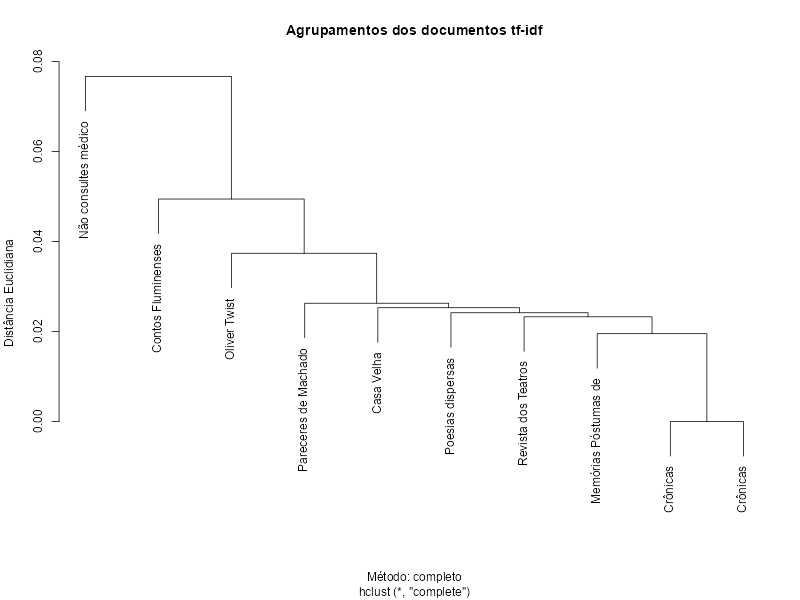

In [79]:
# instala pacotes
install.packages('quanteda')
install.packages('quanteda.textplots')
install.packages("stopwords")
install.packages('openxlsx')

# carrega pacotes
library(quanteda)
library(quanteda.textplots)
library(openxlsx)
library(stopwords)
library(stringr)

# exibição de números decimais
options(scipen=9999)

# carrega coleção
obras <- read.xlsx('machado.xlsx')
# seleciona 10 obras aleatoriamente
obras <- obras[sample(1:nrow(obras),10,replace=TRUE),]

# converte para minúsculas
obras$texto <- char_tolower(obras$texto)

# tokeniza documento
obras.tokens <- tokens(
  # limites: palavras
  obras$texto,what="word",
  # remove pontuação
  remove_punct=TRUE
)

# remove stopwords da coleção
obras.tokens <- tokens_select(obras.tokens, selection="remove", pattern=stopwords("pt"))

# cria matriz de frequências dos documentos (dfm)
obras.dfm <- dfm(obras.tokens)

# tf-idf
obras.tfidf <- dfm_tfidf(
  # seleciona dfm
  obras.dfm, 
  # esquema: tf*idf
  scheme_tf = "prop"
)

# cria agrupamentos
clusters <- hclust(
    # distância euclidiana
    dist(obras.tfidf, method="euclidean"),
    # método: completo (encontra mais similares)
    method="complete"
  )

# rótulo dos clusters com até 20 caracteres
clusters$labels <- substr(obras$titulo,1,20)

# plota agrupamentos
plot(
  clusters,
  # título do gráfico
  main="Agrupamentos dos documentos tf-idf",
  ylab="Distância Euclidiana",
  xlab="Método: completo",
  # agrupamentos
)

# 2. Distâncias e similaridades entre documentos (*tf-idf*)

In [88]:
# instala e carrega pacote lsa
install.packages('lsa')
library(lsa)

# cria df
similaridade <- data.frame()

# varre banco 
for (doc1 in 1:nrow(obras.tfidf)) {
  
  # seleciona vetor e título do doc1
  vetor1 <- as.numeric(obras.tfidf[doc1,])
  titulo1 <- obras$titulo[doc1]

  for (doc2 in 1:nrow(obras.tfidf)) {

    # seleciona vetor e título do doc2
    vetor2 <- as.numeric(obras.tfidf[doc2,])
    titulo2 <- obras$titulo[doc2]

    # não compara nem armazena quando doc1 = doc2
    if (doc1 != doc2) {

      # similaridade de cosseno
      doc.cosseno <- as.numeric(cosine(vetor1, vetor2))
      # distância euclidiano
      doc.euclid <- as.numeric(dist(rbind(vetor1,vetor2),method="euclidean"))
      
      # adiciona ao df
      similaridade <- rbind(
        similaridade,
        data.frame(
          "doc1"=doc1,
          "tit1"=paste0(doc1,". ",substr(titulo1,1,20)),
          "doc2"=doc2,
          "tit2"=paste0(doc2,". ",substr(titulo2,1,20)),
          "simi.cos"=doc.cosseno,
          "dist.euc"=doc.euclid
        )
      )      
    }   
  }
}

# visualiza resultado
View(similaridade)
# exporta resultado
write.xlsx(similaridade, "./dados/similaridade.xlsx")

# 3. Visualiza similaridades por documento

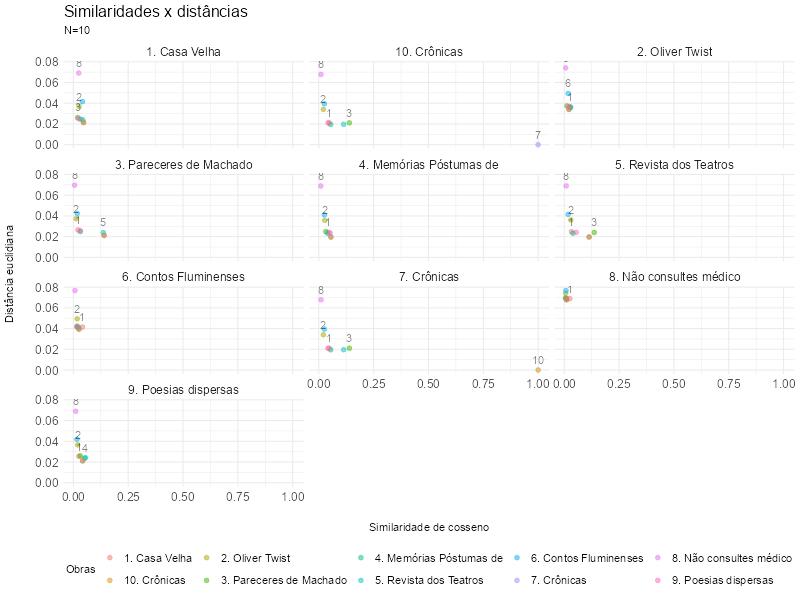

In [92]:
# instala e carrega pacote ggplot2
install.packages('ggplot2')
# carrega pacotes
library(ggplot2)

# plota
ggplot(similaridade) +
  geom_jitter(aes(x=simi.cos, y=dist.euc, colour=tit2), size=2, alpha=0.5, width=0.001) + 
  geom_text(aes(x=simi.cos, y=dist.euc, label=doc2, vjust=-0.75), alpha=0.5, check_overlap = TRUE)+
  # título do gráfico
  labs(
    title="Similaridades x distâncias", 
    # subtítulo
    subtitle=paste0(
      "N=",
      nrow(obras.tfidf)
    ),
    # título da legenda
    colour="Obras"
  )+
  # títulos dos eixos
  xlab("Similaridade de cosseno")+
  ylab("Distância euclidiana")+
  # grade dos gráficos pelo título
  facet_wrap(~tit1,ncol=3)+
  theme_minimal() + 
  theme(
    # título do gráfico
    plot.title = element_text(size=16),
    strip.text = element_text(size=12),
    # fonte e espaçamento do eixo x
    axis.text.x = element_text(size=12),
    axis.title.x = element_text(margin=margin(t=20,b=0,l=0,r=0,unit="pt")),
    # fonte e espaçamento do eixo x
    axis.text.y = element_text(size=12),
    axis.title.y = element_text(margin=margin(t=0,b=0,l=0,r=20,unit="pt")),
    legend.text = element_text(size=11),
    # oculta legenda
    legend.position="bottom"
  )